In [ ]:
!pip install datasets
import pandas as pd
from datasets import load_dataset

# Cargar el dataset de IMDb
dataset = load_dataset("imdb")
# Convertir a DataFrame para una fácil manipulación
train_df_total = pd.DataFrame(dataset['train'])
test_df_total = pd.DataFrame(dataset['test'])

# Sacar una muestra del dataset (30% en este caso)
train_df = train_df_total.sample(frac=0.3, random_state=42)
test_df = test_df_total.sample(frac=0.3, random_state=42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_df

,text,label
6868,"Dumb is as dumb does, in this thoroughly unint...",0
24016,I dug out from my garage some old musicals and...,1
9668,After watching this movie I was honestly disap...,0
13640,This movie was nominated for best picture but ...,1
14018,Just like Al Gore shook us up with his painful...,1
...,...,...
21156,DER TODESKING is not one of my favorite Jorg B...,1
24654,The Woman In Black was a British made for TV m...,1
14592,This is a movie that gets better each time I s...,1
20160,This game ranks above all so far. I had the ho...,1


#1. Tokenización, Eliminación de stopwords y Lematización

Primero quiero ver el texto en crudo

In [ ]:
import nltk

tokens_crudo = []
for text in train_df["text"]:
    tokens_crudo.extend(nltk.wordpunct_tokenize(text))

print(tokens_crudo)
print(f"Hay {len(tokens_crudo)} tokens crudos en nuestra base de datos")

Podemos ver a simple vista que las palabras se repiten por mayúscula/minuscula (dumb), hay signos de puntuacion (,) y palabras que no aportan (as)

Aplicamos entonces una función de normalización para homogeineizar y sacar stopwords al texto y tener tokens valiosos

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer() #voy a usar lemmatizer porque el stemming es más agresivo (comprobado más abajo)
stopwords_en = set(nltk.corpus.stopwords.words('english')) #nuestro texto está en inglés
punctuation = string.punctuation

def normalize(text):
    # Tokenizamos
    text_tokens = nltk.wordpunct_tokenize(text) #separa simbolos de puntuacion como token (para luego eliminarlos ya que nos quedamos solo con alfanumericos)

    # Pasamos a minúsculas y alfanumérico
    text_lower_alpha = [token.lower() for token in text_tokens if token.isalnum()]

    # Eliminamos tokens que contengan números
    text_no_numbers = [token for token in text_lower_alpha if not any(char.isdigit() for char in token)] #para este caso no nos suman los números

    # Eliminamos stop-words
    text_clean = [token for token in text_no_numbers if token not in stopwords_en]

    # Eliminamos signos de puntuación
    text_clean = [token for token in text_clean if token not in punctuation] #por las dudas si queda algo más

    # Lematizamos
    normalized_text = [lemmatizer.lemmatize(word) for word in text_clean]

    return normalized_text

In [ ]:
train_df["Normalized_text"] = train_df["text"].apply(normalize)
corpus_prec = train_df["Normalized_text"]

In [ ]:
train_df.head()

,text,label,Normalized_text
6868,"Dumb is as dumb does, in this thoroughly unint...",0,"[dumb, dumb, thoroughly, uninteresting, suppos..."
24016,I dug out from my garage some old musicals and...,1,"[dug, garage, old, musical, another, one, favo..."
9668,After watching this movie I was honestly disap...,0,"[watching, movie, honestly, disappointed, acto..."
13640,This movie was nominated for best picture but ...,1,"[movie, nominated, best, picture, lost, casabl..."
14018,Just like Al Gore shook us up with his painful...,1,"[like, al, gore, shook, u, painfully, honest, ..."


In [ ]:
tokens_corpus = [token for doc in corpus_prec for token in doc]
counts  = nltk.FreqDist(tokens_corpus)

In [ ]:
vocab   = len(counts.keys())
words   = sum(counts.values())
lexdiv  = float(words) / float(vocab)

print("El corpus tiene %i palabras únicas y un total de %i palabras con una diversidad léxica de %0.3f" % (vocab, words, lexdiv))

El corpus tiene 39911 palabras únicas y un total de 925877 palabras con una diversidad léxica de 23.199


In [ ]:
counts.most_common(20)

[('br', 30492),
 ('movie', 15656),
 ('film', 14436),
 ('one', 8164),
 ('like', 6290),
 ('time', 4751),
 ('good', 4662),
 ('character', 4215),
 ('even', 3828),
 ('story', 3827),
 ('would', 3809),
 ('make', 3705),
 ('get', 3673),
 ('see', 3651),
 ('really', 3585),
 ('scene', 3244),
 ('well', 3139),
 ('much', 2980),
 ('bad', 2939),
 ('people', 2907)]

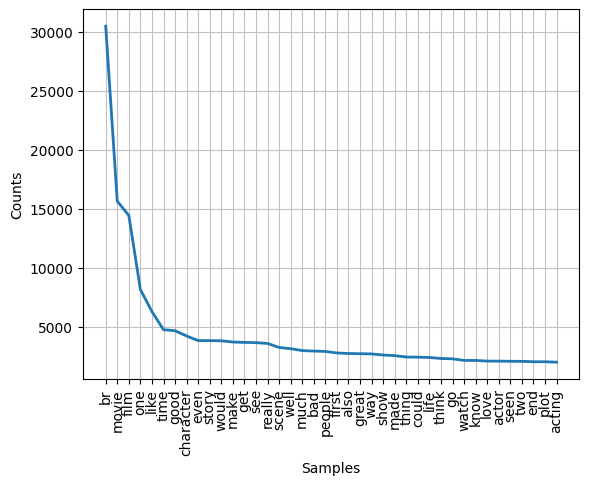

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
counts.plot(40, cumulative=False)

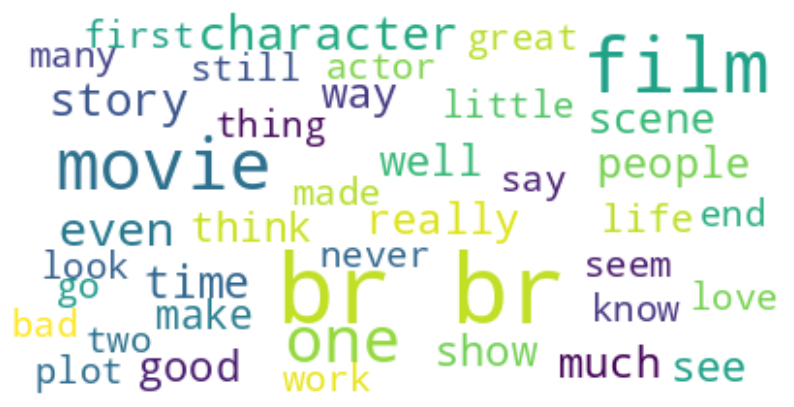

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, max_words=40, background_color="white").generate(' '.join(tokens_corpus))

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

La palabra más frecuente después de preprocesar el texto es "br" por lo que vamos a limpiarla manualmente

In [ ]:
tokens_corpus = [token for doc in corpus_prec for token in doc if token != 'br']
counts  = nltk.FreqDist(tokens_corpus)

In [ ]:
counts.most_common(20)

[('movie', 15656),
 ('film', 14436),
 ('one', 8164),
 ('like', 6290),
 ('time', 4751),
 ('good', 4662),
 ('character', 4215),
 ('even', 3828),
 ('story', 3827),
 ('would', 3809),
 ('make', 3705),
 ('get', 3673),
 ('see', 3651),
 ('really', 3585),
 ('scene', 3244),
 ('well', 3139),
 ('much', 2980),
 ('bad', 2939),
 ('people', 2907),
 ('first', 2778)]

##Prueba Stemming

In [ ]:
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
import string

stemmer = LancasterStemmer()
stopwords_en = set(stopwords.words('english'))
punctuation = string.punctuation

def normalize2(text):
    # Tokenizamos
    text_tokens = nltk.wordpunct_tokenize(text) #separa simbolos de puntuacion como token

    # Pasamos a minúsculas y alfanumérico
    text_lower_alpha = [token.lower() for token in text_tokens if token.isalnum()]

    # Eliminamos tokens que contengan números
    text_no_numbers = [token for token in text_lower_alpha if not any(char.isdigit() for char in token)]

    # Eliminamos stop-words
    text_clean = [token for token in text_no_numbers if token not in stopwords_en]

    # Stemming
    normalized_text = [stemmer.stem(word) for word in text_clean]

    return normalized_text

In [ ]:
prueba_stemmer=train_df["text"].apply(normalize2)
prueba_stemmer

6868     [dumb, dumb, thorough, uninterest, suppos, bla...
24016    [dug, gar, old, mus, anoth, on, favorit, writ,...
9668     [watch, movy, honest, disappoint, act, story, ...
13640    [movy, nomin, best, pict, lost, casablanc, pau...
14018    [lik, al, gor, shook, us, pain, honest, clev, ...
                               ...                        
21156    [der, todesk, on, favorit, jorg, buttgereit, f...
24654    [wom, black, brit, mad, tv, movy, first, broad...
14592    [movy, get, bet, tim, see, many, nuant, perfor...
20160    [gam, rank, far, hon, play, min, graph, real, ...
4731     [opportun, mak, on, best, rom, tragedy, maf, m...
Name: text, Length: 7500, dtype: object

In [ ]:
prueba_stemmer = [token for doc in prueba_stemmer for token in doc]
counts2  = nltk.FreqDist(prueba_stemmer)
counts2.most_common(20)

[('br', 30492),
 ('movy', 15656),
 ('film', 14814),
 ('on', 8170),
 ('act', 7585),
 ('lik', 7022),
 ('ev', 6410),
 ('real', 6196),
 ('tim', 4922),
 ('mak', 4854),
 ('good', 4727),
 ('watch', 4373),
 ('see', 4342),
 ('charact', 4338),
 ('get', 4136),
 ('story', 3829),
 ('would', 3812),
 ('us', 3527),
 ('com', 3294),
 ('scen', 3257)]

Acá confirmamos que las palabras pierden sentido como (movy, lik, tim, scen, etc) asi que nos quedamos con el Lemmatizer

#2. Vectorización Bag of Words

Utilizaré la vectorización mediante Bag of Words porque quiero predecir el sentimiento de un tweet y si uso TD-IDF puedo perder alguna palabra que se repita en todos los textos pero que sea importante para detectar el sentimento.

In [ ]:
import gensim

D = gensim.corpora.Dictionary(corpus_prec) #diccionario
n_tokens = len(D)

print('El diccionario contiene', n_tokens, 'palabras')
print('Primeras 10 palabras:')
for n in range(10):
    print(str(n), ':', D[n])

El diccionario contiene 39911 palabras
Primeras 10 palabras:
0 : amigo
1 : billy
2 : black
3 : bob
4 : busey
5 : cannot
6 : character
7 : chris
8 : comedy
9 : dead


In [ ]:
corpus_bow = [D.doc2bow(doc) for doc in corpus_prec] #vectorizo

In [ ]:
print("Representación del vector:")
print(corpus_bow[:5])

print('Recuentos de palabras:')
word_counts = []
for doc in corpus_bow[:5]:
    for index, count in doc:
        word_counts.append((D.get(index), count)) #porque son tuplas de id de palabra y su frecuencia
print(word_counts)

Representación del vector:
[[(0, 1), (1, 1), (2, 3), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 3), (9, 3), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 2), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 3), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2)], [(25, 1), (28, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (

#3. Modelo de clasificacion (Regresión Logística) para predecir la polaridad del sentimiento (positivo o negativo).

In [ ]:
train_df["label"].value_counts()

label
0    3752
1    3748
Name: count, dtype: int64

Están balanceadas

In [ ]:
#ya tengo los datasets divididos en train y test, asi que no hace falta hacer test, train split

X_train = train_df["text"]
y_train = train_df["label"]
X_test = test_df["text"]
y_test = test_df["label"]

len(X_train), len(X_test)

(7500, 7500)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import gensim

# Función para vectorizar con BoW utilizando el diccionario creado previamente
def vectorize_with_bow(text, D):
    return D.doc2bow(text.split())

# Vectorizar X_train y X_test con BoW
X_train_bow = [vectorize_with_bow(doc, D) for doc in X_train]
X_test_bow = [vectorize_with_bow(doc, D) for doc in X_test]

# Convertir a formato numpy
X_train_bow_np = gensim.matutils.corpus2dense(X_train_bow, num_terms=len(D)).T
X_test_bow_np = gensim.matutils.corpus2dense(X_test_bow, num_terms=len(D)).T

#Evaluar modelo

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.82


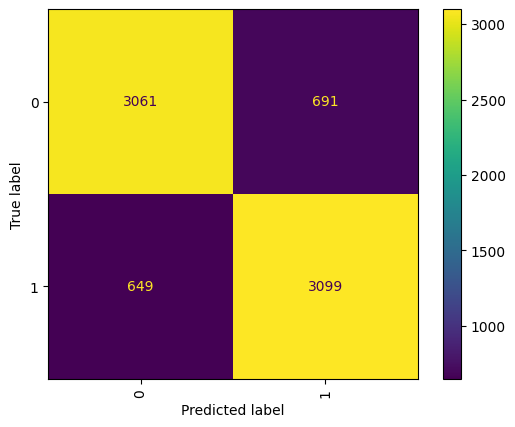

In [ ]:
# Entrenar y evaluar el modelo de Regresión Logística
def test(clf):
    clf.fit(X_train_bow_np, y_train)
    y_pred = clf.predict(X_test_bow_np)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(xticks_rotation="vertical")

    return clf

# Crear y probar el modelo de Regresión Logística
model = LogisticRegression(random_state=0)
trained_model = test(model)

Podemos decir que el modelo es bueno, con un accuracy de 0.82. Es decir, el 82% de las predicciones realizadas por el modelo son correctas en relación con el total de predicciones. Veamos las otras métricas

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = trained_model.predict(X_test_bow_np)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Precision: 0.82
Recall: 0.83
F1-score: 0.82


Todas las métricas son altas. Esto significa que el 82% de las veces que el modelo predice que un comentario es positivo, realmente lo es (precisión), que identifica correctamente el 83% de todos los comentarios positivos presentes en el conjunto de prueba (recall). F1-score es una combinación de ambas

#5. Otras técnicas más avanzadas

Para poder optimizar el objetivo de predicción de sentimiento, podemos usar Word2Vec para conservar el significado semántico del texto. Además, vimos que Word2Vec contiene un modelo pre-entrenado para detección de sentimiento, lo cual es muy útil ahora:

In [ ]:
from nltk.data import find
import gensim
import gensim.downloader

model = gensim.downloader.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
import numpy as np  # Importa la biblioteca numpy, utilizada para operaciones matemáticas y manejo de arreglos.

def embed_in_word_2_vec(text):
    # Define una función llamada embed_in_word_2_vec que toma un parámetro text.

    prepocessed_words = normalize(text)
    # Llama a la función normalize para procesar el texto de entrada.
    # El resultado es una lista de palabras preprocesadas.

    representations = []
    # Inicializa una lista vacía llamada representations que almacenará los vectores de word2vec.

    for word in prepocessed_words:
        # Itera sobre cada palabra en la lista de palabras preprocesadas.

        if word in model: # acordemosnos que definimos esto: model = gensim.downloader.load('glove-twitter-200')
            # Verifica si la palabra actual está presente en el modelo word2vec.

            representations.append(model[word])
            # Si la palabra está en el modelo, agrega su vector de word2vec a la lista representations.

    if representations:
        # Verifica si la lista representations no está vacía.

        return np.vstack(representations).mean(axis=0)
        # Si representations no está vacía, apila verticalmente los vectores y calcula la media a lo largo del primer eje.
        # Devuelve un único vector promedio que representa el texto completo.
    else:
        return np.zeros(200)
        # Si representations está vacía, devuelve un vector de ceros de tamaño 200.

In [ ]:
X_train_embedded = list(map(embed_in_word_2_vec, X_train.tolist())) #aplico vector a cada palabra
X_test_embedded = list(map(embed_in_word_2_vec, X_test.tolist()))

In [ ]:
X_train_embedded_np = np.concatenate([np.expand_dims(v, axis=0) for v in X_train_embedded], axis=0)
X_test_embedded_np = np.concatenate([np.expand_dims(v, axis=0) for v in X_test_embedded], axis=0)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test(clf):
  clf.fit(X_train_embedded_np, y_train)
  y_pred = clf.predict(X_test_embedded_np)

  print(f"accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}")

  return ConfusionMatrixDisplay.from_estimator(
      clf, X_test_embedded_np, y_test,  xticks_rotation="vertical")

Probamos nuevamente con Logistic Regression para ver si mejoró

In [ ]:
clf = LogisticRegression()
clf.fit(X=X_train_embedded_np, y=y_train)

LogisticRegression()

accuracy: 0.7746666666666666


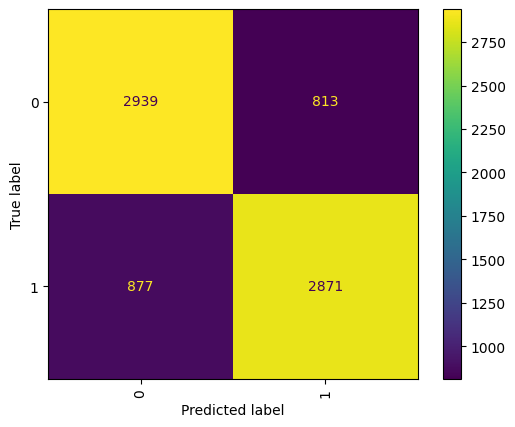

In [ ]:
clf.score(X=X_test_embedded_np, y=y_test)
test(clf)

Da peor que el modelo que entrené previamente con BoW

Sumamos la evaluación de Random Forest para ver si es mejor

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=42)
clf.fit(X=X_train_embedded_np, y=y_train)

RandomForestClassifier(max_depth=2, random_state=42)

accuracy: 0.6896


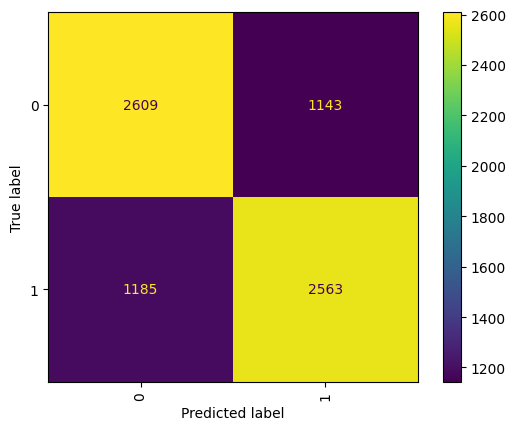

In [ ]:
clf.score(X=X_test_embedded_np, y=y_test)
test(clf)

Da incluso peor

Esto se puede deber a que el modelo pre-entrenado de Word2Vec de Glove twitter 200 no sea el indicado para comentarios de películas o series.

Voy a intentar entrenando el Word2Vec en lugar de utilizar un modelo pre-entrenado

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

model = Word2Vec(sentences=train_df['Normalized_text'], vector_size=200, window=5, min_count=1, workers=4)

In [ ]:
def get_avg_vector(text, model):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

def predict_sentiment(text, model, clf, threshold=0.5):
    avg_vector = get_avg_vector(text, model)
    prediction = clf.predict(avg_vector.reshape(1, -1))
    return prediction[0]  # Devuelve la predicción del sentimiento (0 o 1)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Entrenar el modelo de Regresión Logística
clf = LogisticRegression()
clf.fit(X_train_embedded_np, y_train)

LogisticRegression()

accuracy: 0.7746666666666666


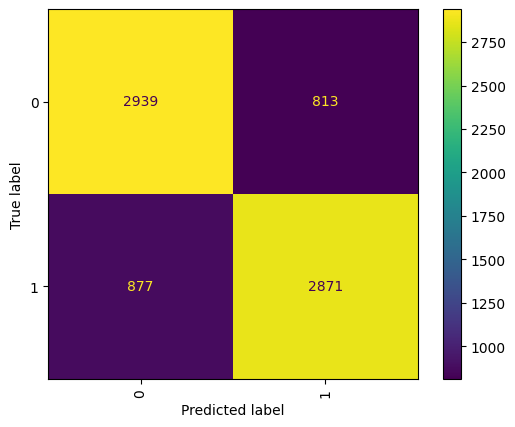

In [ ]:
clf.score(X=X_test_embedded_np, y=y_test)
test(clf)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train_embedded_np, y_train)

DecisionTreeClassifier()

accuracy: 0.6005333333333334


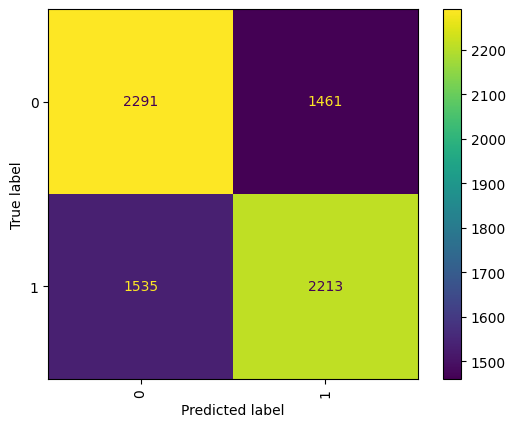

In [ ]:
clf.score(X=X_test_embedded_np, y=y_test)
test(clf)

Sigue dando peor. El mejor modelo de vectorización para este caso es el BoW. Intento con pysentimiento

In [ ]:
!pip install pysentimiento

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 20.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [ ]:
train_df = pd.DataFrame({"text": X_train, "positive": y_train})
train_df["positive"] = train_df["positive"].astype("bool")

In [ ]:
train_df

,text,positive
6868,"Dumb is as dumb does, in this thoroughly unint...",False
24016,I dug out from my garage some old musicals and...,True
9668,After watching this movie I was honestly disap...,False
13640,This movie was nominated for best picture but ...,True
14018,Just like Al Gore shook us up with his painful...,True
...,...,...
21156,DER TODESKING is not one of my favorite Jorg B...,True
24654,The Woman In Black was a British made for TV m...,True
14592,This is a movie that gets better each time I s...,True
20160,This game ranks above all so far. I had the ho...,True


In [ ]:
def predict_sentiment (text):
    if isinstance(text, float) and np.isnan(text):
        return np.nan
    else:
        return analyzer.predict(str(text)).output

In [ ]:
# Tomar el 1% de la muestra
sample_size = int(len(train_df) * 0.01)
sampled_df = train_df.sample(n=sample_size, random_state=42)

# Aplicar la función predict_sentiment a la columna 'text'
sampled_df['Sentimiento'] = sampled_df['text'].apply(predict_sentiment)

                                                    text Sentimiento
17177  It's very sly for all of the 60's look to the ...         POS
11072  The various nudity scenes that other reviewers...         NEG
11766  "Scary Movie 2" is a let down to the Scary Mov...         NEG
1794   This film, although not totally bad, should ha...         NEG
1086   What's up with Robert "Pretentious" Altman? Wa...         NEG
...                                                  ...         ...
15377  Cinderella was one of the first movies I ever ...         POS
12461  I've been reading posts here concerning Wonder...         NEU
12830  Before I watched this tv movie I did not know ...         POS
18737  Mitchell Leisen's fifth feature as director, a...         POS
13758  "Night of the Living Homeless" was a fairly st...         NEU

[75 rows x 2 columns]


Como era de esperarse, el modelo tardaba mucho así que lo cancelé y tomé una muestra nada mas como dicho en clase para terminos de examen

In [ ]:
sampled_df[['text', 'Sentimiento']]

,text,Sentimiento
17177,It's very sly for all of the 60's look to the ...,POS
11072,The various nudity scenes that other reviewers...,NEG
11766,"""Scary Movie 2"" is a let down to the Scary Mov...",NEG
1794,"This film, although not totally bad, should ha...",NEG
1086,"What's up with Robert ""Pretentious"" Altman? Wa...",NEG
...,...,...
15377,Cinderella was one of the first movies I ever ...,POS
12461,I've been reading posts here concerning Wonder...,NEU
12830,Before I watched this tv movie I did not know ...,POS
18737,"Mitchell Leisen's fifth feature as director, a...",POS


<ipython-input-115-dc240d79186e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['sentimiento_binario'] = sampled_df['Sentimiento'].apply(lambda x: True if x in ['POS'] else False)


Accuracy: 0.89


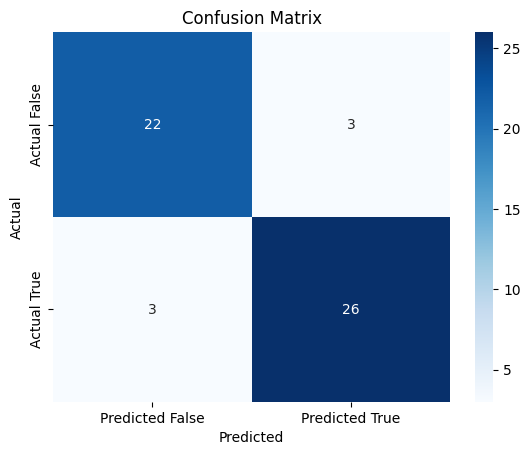

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar el DataFrame para excluir la categoría "neutro"
df_filtrado = sampled_df.loc[sampled_df['Sentimiento'] != 'NEU']

# Convertir sentimiento a binario
df_filtrado['sentimiento_binario'] = sampled_df['Sentimiento'].apply(lambda x: True if x in ['POS'] else False)

# Calcular la precisión
accuracy = accuracy_score(df_filtrado['positive'], df_filtrado['sentimiento_binario'])
print(f'Accuracy: {accuracy:.2f}')

# Crear la matriz de confusión
cm = confusion_matrix(df_filtrado['positive'], df_filtrado['sentimiento_binario'])

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted False', 'Predicted True'], yticklabels=['Actual False', 'Actual True'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Ahora, si puedo decir que me dió mejor que con BoW, asi que de esta manera mejoraría el análisis de sentimiento (pero hay que tomar en cuenta que tomé 1% del dataset)

Más análisis de sentimientos

In [ ]:
from pysentimiento import create_analyzer
import transformers

transformers.logging.set_verbosity(transformers.logging.ERROR)

analyzer = create_analyzer(task="sentiment", lang="en")

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [ ]:
random_row = train_df.sample(n=1).iloc[0]
random_text = random_row['text']
print(random_text)
print(analyzer.predict(random_text))
true_label = random_row['label']
print(f"Valor real: {true_label}")

`Stanley and Iris' is a heart warming film about two people who find each other and help one another overcome their problems in life. Stanley's life is difficult, because he never learned to read or write. Iris is a widower with two teenage children working in a bakery where she meets Stanley. She decides to teach Stanley how to read at her home in her spare time. Over time they become romantically involved. After Stanley learns to read, he goes off to a good job in Chicago, only to return to Iris and ask her to marry him.<br /><br />It's a really good film without nudity, violence, or profanity, that which is rare in today's films. A good film all round. <br /><br />
AnalyzerOutput(output=POS, probas={POS: 0.780, NEU: 0.214, NEG: 0.006})
Valor real: 1


Iterando sobre el codigo anterior se puede ver como califica de manera correcta si un texto es negativo o positivo

In [ ]:
emotion_analyzer = create_analyzer(task="emotion", lang="en")

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Más evaluación de sentimiento/emociones

In [ ]:
random_row = train_df.sample(n=1).iloc[0]
random_text = random_row['text']
print(random_text)
print(emotion_analyzer.predict(random_text))

A great British Indy movie! Fantastic chemistry between the 3 main characters make for some hilarious drug-fuelled set pieces that Cheech and Chong would be proud of. Great to see Phil Daniels back on the big screen (even if he has swapped sides since Quadrophenia!) and Gary Stretch is surprisingly good and a treat for the ladies! Loved the final fight scene with it's nod to Zulu and now I know what happened to Arthur Brown after he set himself on fire on Top of the Pops!...he's not acting....he really is a bona-fide British hippie!!! You don't have to be a biker to enjoy this and it's straight into my Friday night post-pub repeat viewing collection. <br /><br />Give this film a go and you won't be disappointed.
AnalyzerOutput(output=joy, probas={joy: 0.746, others: 0.241, surprise: 0.005, disgust: 0.003, anger: 0.002, fear: 0.002, sadness: 0.001})


In [ ]:
hate_speech_analyzer = create_analyzer(task="hate_speech", lang="en")

config.json:   0%|          | 0.00/980 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [ ]:
random_row = train_df.sample(n=1).iloc[0]
random_text = random_row['text']
print(random_text)
print(hate_speech_analyzer.predict(random_text))

This movie was a fairly entertaining comedy about Murphy's Law being applied to home ownership and construction. If a film like this was being made today no doubt the family would be dysfunctional. Since it was set in the 'simpler' forties, we get what is supposed to be a typical family of the era. Grant of course perfectly blends the comedic and dramatic elements and he works with a more than competent supporting cast highlighted by Loy and Douglas. Their shenanigans make for a solid ninety minutes of entertainment, 7/10.
AnalyzerOutput(output=[], probas={hateful: 0.014, targeted: 0.010, aggressive: 0.011})


Parece ser que no hay muchos comentarios agresivos o con odio, sino más bien los negativos son con "respeto" o críticas constructivas

#6. Algoritmos Genéticos

Recordando el problema visto en clase:
- conseguir que una población de 200 elementos llegue al objetivo de la frase "To be or not to be." con una mutation rate de 1%

Para mejorar la función de aptitud se podría:
1. **Cambiar la función de aptitud a exponencial** ya que el esfuerzo de encontrar los últimos caracteres es más difícil. Por eso es exponencial, al principio es fácil pero los últimos son más difíciles. Elevando la aptitud a un exponencial logro encontrar el resultado en menos generaciones ya que el salto que da es cada vez más grande llegando a los últimos caracteres
- cambio de: this.fitness = score / target.length
- a: this.fitness = Math.pow(score, 2) / target.length
2. Cambiando el método de selección de padres. En el ejemplo visto en clase, usamos matingpool el cual selecciona los padres sacando de un array los elementos que aparecen tantas cantidades como función de aptitud tenga. Se podría sumar 0.01 al fitness para aquellos elementos que tengan fitness 0. Pero, al ser una población grande (200), es más eficiente utilizar otro métiodo de selección de padres, como el accept/reject o el método del dardo.
- Por un lado, el accept/reject seria tomar un numero random y compararlo con la fitness fuction de un elemento. Si la fitness es mayor, lo acepto. Un problema que puede surgir es que las fitness function sean muy chicas, por lo que tardaría.
- Por esa razón, el mejor método sería el del dardo que comienza igual que el de accept/reject solo que si la fitness function es menor que el numero random (osea n random - fitness > 0), bajo ese elemnto y le resto su fitness al numero random para que, al tomar el segundo elemento, ahora sea (n random - fitness de el1) - fitness el2 < 0) si esto se cumple, lo tomo.

La parte del codigo que cambiaría es la que sigue ya que acá se define el metodo de seleccion de padres como mating pool:
class Population {
  constructor(p, m, num) {
    this.population; // Array to hold the current population
    this.matingPool; // ArrayList which we will use for our "mating pool"
    this.generations = 0; // Number of generations
    this.finished = false; // Are we finished evolving?
    this.target = p; // Target phrase
    this.mutationRate = m; // Mutation rate
    this.perfectScore = 1;

    this.best = "";

    this.population = [];
    for (let i = 0; i < num; i++) {
      this.population[i] = new DNA(this.target.length);
    }
    this.matingPool = [];
    this.calcFitness();
  }

  // Fill our fitness array with a value for every member of the population
  calcFitness() {
    for (let i = 0; i < this.population.length; i++) {
      this.population[i].calcFitness(target);
    }
  }

  // Generate a mating pool
  naturalSelection() {
    // Clear the ArrayList
    this.matingPool = [];

    let maxFitness = 0;
    for (let i = 0; i < this.population.length; i++) {
      if (this.population[i].fitness > maxFitness) {
        maxFitness = this.population[i].fitness;
      }
    }

    // Based on fitness, each member will get added to the mating pool a certain number of times
    // a higher fitness = more entries to mating pool = more likely to be picked as a parent
    // a lower fitness = fewer entries to mating pool = less likely to be picked as a parent
    for (let i = 0; i < this.population.length; i++) {
      let fitness = map(this.population[i].fitness, 0, maxFitness, 0, 1);
      let n = floor(fitness * 100); // Arbitrary multiplier, we can also use monte carlo method
      for (let j = 0; j < n; j++) {
        // and pick two random numbers
        this.matingPool.push(this.population[i]);
      }
    }
  }

  Al codigo del método del dardo que no vimos.



**Como vimos, cada problema de algoritmo genético tiene su genoma y fitness function únicos**.

Por ejemplo, para que el algoritmo imprima mi numero de telefono, tengo que cambiar los elementos del genoma de:

function newChar() {
  let c = floor(random(63, 122));
  if (c === 63) c = 32;
  if (c === 64) c = 46;

  return String.fromCharCode(c);
}

a solo numeros, en lugar de letras

Por otra parte, si mi problema es llegar a un determinado lugar rápido, la fitness function debería adaptarse a "premiar" por menor tiempo y "castigar" por mayores km recorridos. Esto es lo que deberíamos cambiar:

calcFitness(target) {
    let score = 0;
    for (let i = 0; i < this.genes.length; i++) {
      if (this.genes[i] == target.charAt(i)) {
        score++;
      }
    }
    this.fitness = score / target.length;

